# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [207]:
#declare libraries
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
import datetime
from dateutil.relativedelta import relativedelta 
import os
import requests 
import zipfile 
import io 
import pandas as pd
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import subprocess as sp
import os
import time
import pylab as pl
import scipy.stats
from shapely.geometry import Point
import statsmodels.formula.api as smf
import geopandas as gpd
import random
import json
from fiona.crs import from_epsg
import pysal as ps
import math
import matplotlib.pylab as plt
import seaborn as sbn
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import sklearn.cluster
from scipy.cluster.vq import kmeans2
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AffinityPropagation

#declare enviromental variable
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
    puidata = os.getenv("PUIDATA")

In [40]:
#download zipcode shape file
url = "https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip"
output_path = puidata
r = requests.get(url, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(output_path)
nyczipsshp = gpd.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")

In [41]:
NYCzipcodes = nyczipsshp.ZIPCODE.values

In [61]:
#load data from github in a replicable manner, uh i downloaded the zip then directly loaded in to memory so i don't store it in a "physical" drive
#should that be an issue? since i don't move it to the pui output folder? i'll make a copy to be saved in the pui folder
for year in range(1994,2015):
    url = "https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp{}totals.zip".format(str(year)[2:])
    fname = url.split("/")[-1]
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    df = pd.read_csv(z.open(fname.replace('.zip','.txt')),dtype={'zip': object})
    df['year'] = year #create year column to keep track
    #ensure column names are the same since there's a format change
    df.columns = [c.lower() for c in df.columns]
    #filter by nyc zip codes
    df = df[df.zip.apply(lambda x: x in NYCzipcodes)]
    if year!= 1994:
        super_df = pd.concat([super_df,df],axis=0,ignore_index=True)
    else:
        super_df = df.copy()

In [28]:
#output full table to puidata
output = puidata
super_df.to_csv(output+"/zbptotals_93_14.csv")

In [45]:
super_df.head()

,ap,ap_nf,city,cty_name,emp,emp_nf,empflag,est,name,qp1,qp1_nf,stabbr,year,zip
0,3375875,NaN,NaN,NaN,106160,NaN,NaN,6999,"New York, NY",781628,NaN,NaN,1994,10001
1,258318,NaN,NaN,NaN,13500,NaN,NaN,1784,"New York, NY",60207,NaN,NaN,1994,10002
2,2194890,NaN,NaN,NaN,59001,NaN,NaN,3256,"New York, NY",497286,NaN,NaN,1994,10003
3,2615639,NaN,NaN,NaN,39428,NaN,NaN,1115,"New York, NY",685819,NaN,NaN,1994,10004
4,2937365,NaN,NaN,NaN,43540,NaN,NaN,1076,"New York, NY",807612,NaN,NaN,1994,10005


# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [56]:
#import geopandas as gp
#nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
#nyczipsshp.plot()
#nyczipsshp.drop_duplicates("ZIPCODE").plot()
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [91]:
#pivotdf = pd.pivot_table(super_df, values='est', index='zip',columns='year',aggfunc='sum')
pivotdf = pd.pivot_table(super_df, values='est', index='zip',columns='year')
pivotdf.dropna(axis=0, inplace=True)
#cleancsb = np.array(pivotdf)
cleancsb = pivotdf.copy()

In [92]:
#then the standardization will look like:
vals = ((cleancsb.T - cleancsb.mean(axis=1)) / cleancsb.std(axis=1)).T

vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

In [124]:
#i wanted to find the optimal k for k-means, i used average silhouette_score to determine this (although the examples show me this, i want to have an algorithmic way to prove this)
#i referred to this https://plot.ly/scikit-learn/plot-kmeans-silhouette-analysis/

#Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
for k in range(2,10):
    clusterer = KMeans(n_clusters=k)
    cluster_labels = clusterer.fit_predict(cleancsb.T)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(cleancsb.T, cluster_labels)
    print("For n =", k,
              "The average silhouette_score is :", silhouette_avg)
#according to this, i should use n = 5

For n = 2 The average silhouette_score is : 0.493609382561
For n = 3 The average silhouette_score is : 0.498076867293
For n = 4 The average silhouette_score is : 0.525327796799
For n = 5 The average silhouette_score is : 0.557701654341
For n = 6 The average silhouette_score is : 0.49958706721
For n = 7 The average silhouette_score is : 0.493761600355
For n = 8 The average silhouette_score is : 0.561919604635
For n = 9 The average silhouette_score is : 0.609998553371


In [101]:
#cluster with kmeans
nc = 5
km = KMeans(n_clusters=nc, random_state=444).fit(vals)

In [102]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km.labels_.shape

(231,)

In [184]:
vals['clusters'] = km.labels_
vals.head()

year,1994,1995,1996,1997,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,clusters
zip,,,,,,,,,,,,,,,,,
10001,-1.693673,-1.117241,-1.201439,-0.689775,-1.143148,0.709205,0.333553,1.000659,1.868545,1.369835,0.288216,-0.126297,-0.216971,-0.165157,0.080960,0.702728,2
10002,-1.801971,-1.719237,-1.482855,-1.175558,-0.341129,0.011080,0.320741,0.330196,0.327833,0.342016,0.540577,0.769867,0.864420,0.963701,1.044071,1.006249,0
10003,-1.847281,-1.491780,-1.374259,-1.027573,-0.531047,-0.319510,-0.052150,0.071247,0.482570,0.547206,0.629471,0.670603,0.805752,0.967343,1.152439,1.316968,0
10004,-1.514857,-1.446964,-1.379071,-1.077326,-0.481378,-0.247526,-0.421029,-0.036304,0.408771,0.454033,0.476664,0.619993,0.665255,0.951913,1.231027,1.796800,0
10005,-2.425416,-1.934004,-0.340638,-0.176834,-0.578898,-0.191725,-0.370420,0.299687,0.508165,0.776208,0.523056,0.403926,0.925120,0.508165,0.850664,1.222946,0


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


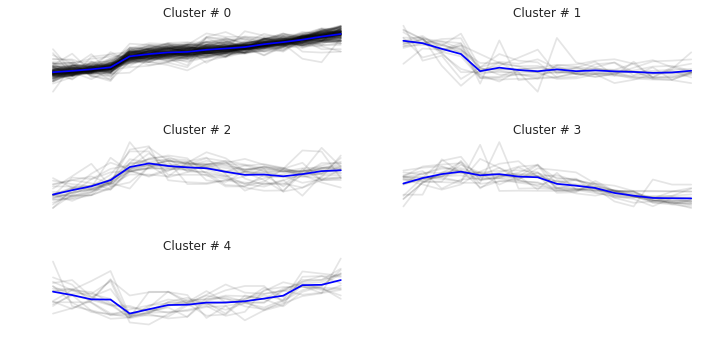

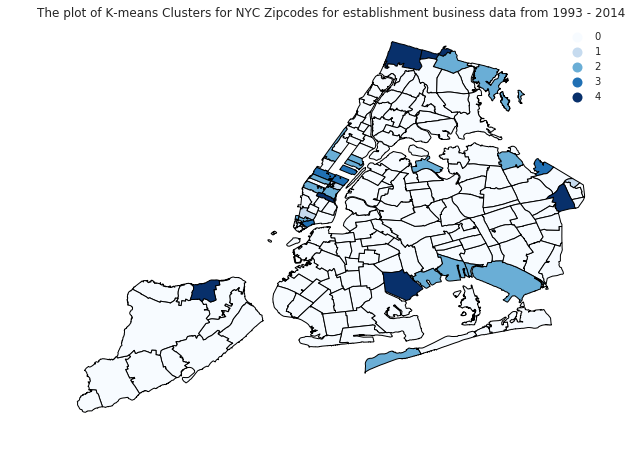

In [192]:
fig = pl.figure(figsize=(10,5))

for i in range(nc):
    cluster = vals[vals['clusters'] == i]
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(range(cluster.shape[1]-1),cluster.iloc[:,:-1].T, 'k-', alpha=0.1)
    ax.plot(range(cluster.shape[1]-1),km.cluster_centers_[i], 'b-')
    ax.set_title('Cluster # {}'.format(i))
    ax.set_axis_off()
    
pl.tight_layout()

kmeans_geo = nyczipsshp.merge(vals[['clusters']], left_on='ZIPCODE', right_index=True)

fig2 = pl.figure(figsize=(10,7.5))
ax2 = fig2.add_subplot(111)

kmeans_geo.plot(ax=ax2, column='clusters', cmap='Blues', edgecolor='k', lw=1,  categorical=True, legend=True)
ax2.set_title('The plot of K-means Clusters for NYC Zipcodes for establishment business data from 1993 - 2014')
ax2.axis('off');

### Figure 1: 
cloropleth of  cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

I don't seem to notice anything in particular with the k-means results. Other than areas around Midtown towards some nearby areas of Central Park

### or maybe like this, depending on which algorithm you use, and how you proceed to preprocess your data and how you cluster it. There is no one correct answer, but general trends should be retrieved.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


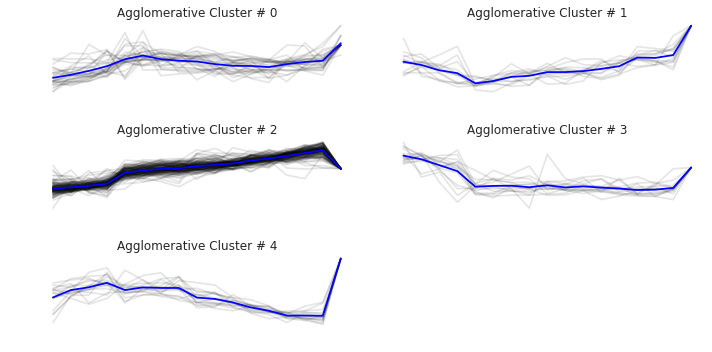

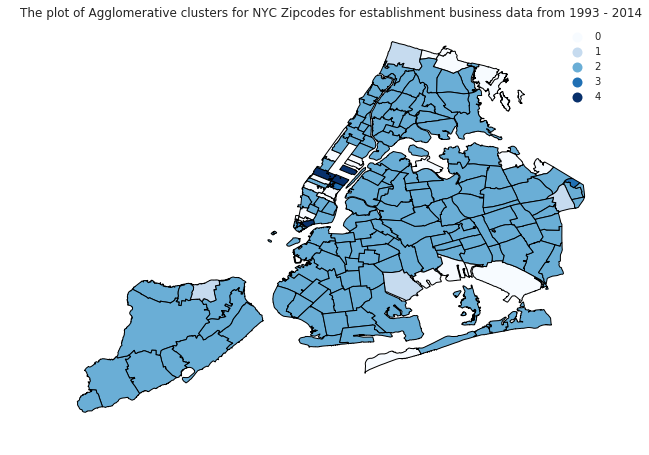

In [200]:
#doing agglomerative clustering
agc = AgglomerativeClustering(n_clusters=nc,  compute_full_tree=True).fit(vals)
vals['ag_clusters'] = agc.labels_

fig = pl.figure(figsize=(10,5))

for i in range(nc):
    cluster = vals[vals['ag_clusters'] == i]
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(range(cluster.shape[1]-1),cluster.iloc[:,:-1].T, 'k-', alpha=0.1)
    ax.plot(range(cluster.shape[1]-1),cluster.iloc[:,:-1].mean(), 'b-')
    ax.set_title('Agglomerative Cluster # {}'.format(i))
    ax.set_axis_off()
    
pl.tight_layout()

agglo_geo = nyczipsshp.merge(vals[['ag_clusters']], left_on='ZIPCODE', right_index=True)

fig2 = pl.figure(figsize=(10,7.5))
ax2 = fig2.add_subplot(111)

agglo_geo.plot(ax=ax2, column='ag_clusters', cmap='Blues', edgecolor='k', lw=1,  categorical=True, legend=True)
ax2.set_title('The plot of Agglomerative clusters for NYC Zipcodes for establishment business data from 1993 - 2014')
ax2.axis('off');

### Figure 2: 
cloropleth of  agglomerative clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

This seems to better categorize a lot more zipcodes, but i think i get more from k-means as most of the resulting clusters look at around category 2. Still, same with the k-means, there seems to be something notable near south of central park. this should be the areas around time square.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


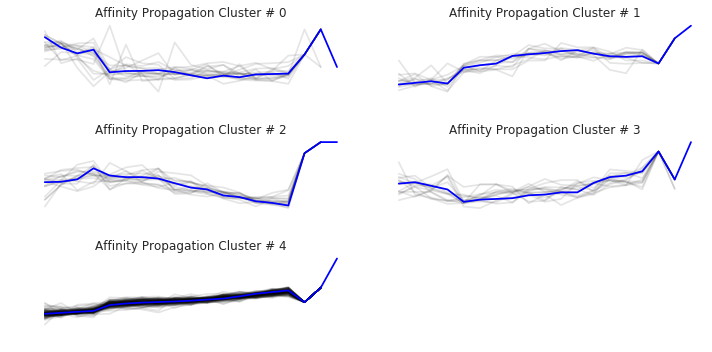

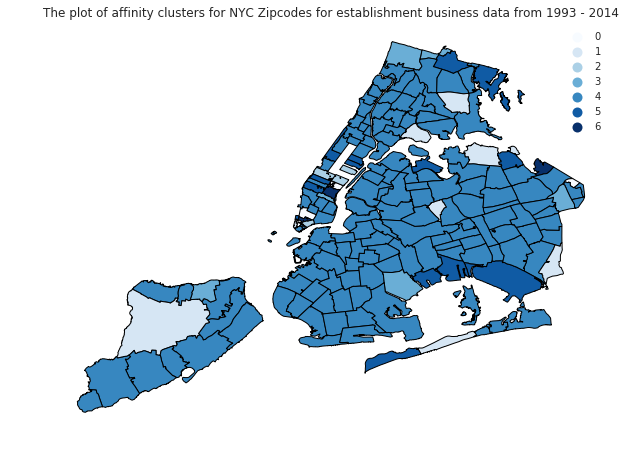

In [211]:
#performing affinity propogation
aff = AffinityPropagation(preference=-100).fit(vals)
vals['aff_clusters'] = aff.labels_

fig = pl.figure(figsize=(10,5))

for i in range(nc):
    cluster = vals[vals['aff_clusters'] == i]
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(range(cluster.shape[1]-1),cluster.iloc[:,:-1].T, 'k-', alpha=0.1)
    ax.plot(range(cluster.shape[1]),aff.cluster_centers_[i], 'b-')
    ax.set_title('Affinity Propagation Cluster # {}'.format(i))
    ax.set_axis_off()
    
pl.tight_layout()

aff_geo = nyczipsshp.merge(vals[['aff_clusters']], left_on='ZIPCODE', right_index=True)

fig2 = pl.figure(figsize=(10,7.5))
ax2 = fig2.add_subplot(111)

aff_geo.plot(ax=ax2, column='aff_clusters', cmap='Blues', edgecolor='k', lw=1,  categorical=True, legend=True)
ax2.set_title('The plot of affinity clusters for NYC Zipcodes for establishment business data from 1993 - 2014')
ax2.axis('off');

### Figure 3: 
cloropleth of affinity propogration generated clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

Patterns are mostly similar with k-means and agglomerative. I'm starting to believe, i need to do more pre-processing but as expected some patterns tend to commonly show up across different type of clustering methods.

# If you want to use agglomerative clustering

### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


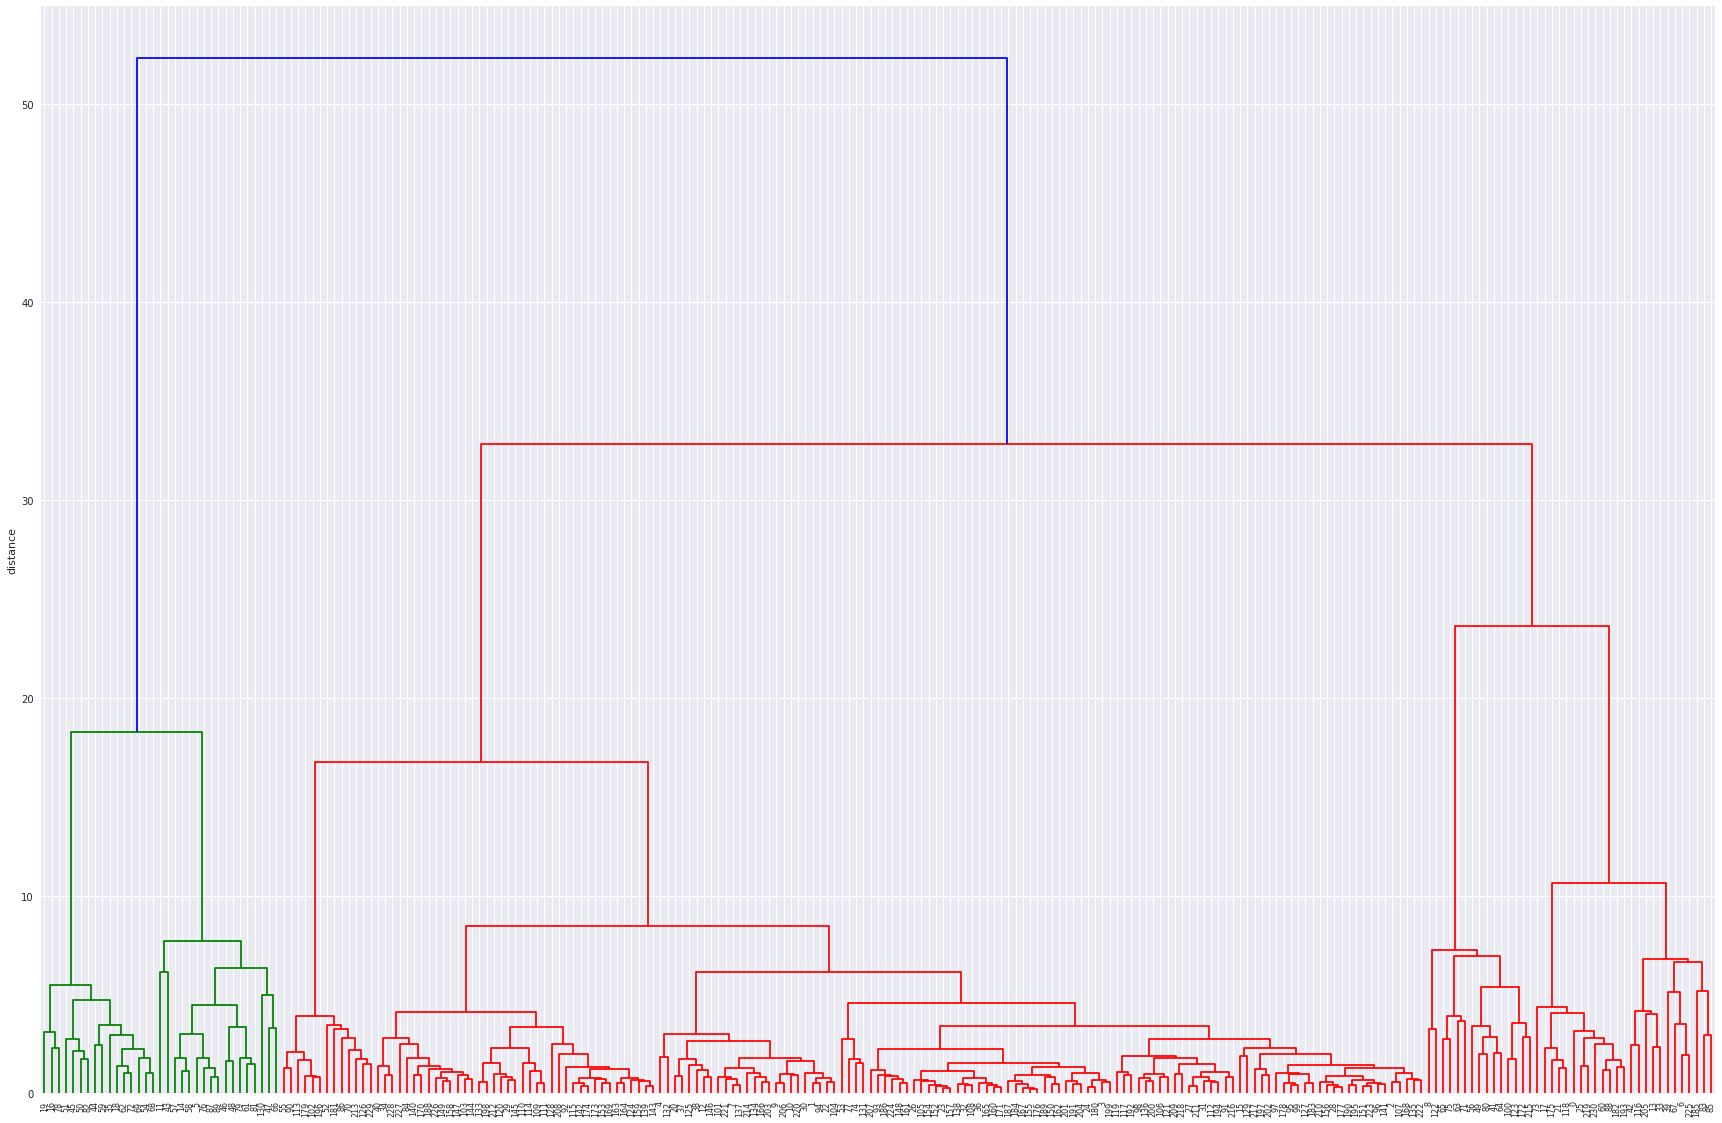

In [214]:
import scipy.cluster as scp
fig = pl.figure(figsize=(30,20))
pl.ylabel("distance")
hier=scp.hierarchy.linkage(vals, method='ward')
ddg =scp.hierarchy.dendrogram(hier,
#                               labels = zip,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels)


# figure 4:
Dendogram of the zipcodes, there seems to be only two clusters based from the graph.